### Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [1]:
%matplotlib inline
import sys, os, glob, warnings

warnings.filterwarnings('ignore', category=UserWarning, module='astroquery')

from astropy.io import fits, ascii

from astroquery.simbad import Simbad
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.wcs import WCS
from astropy.table import Column, Table

In [2]:
# A token is needed to access ADS. Here I used mine. A token is available at https://ui.adsabs.harvard.edu/user/settings/token

from astroquery import nasa_ads as na

na.ADS.TOKEN = 'Gh2X1K7QxOgpUq0kU3eG3QWNuer5wV6CaIjgkGdp'
na.ADS.NROWS = 20
na.ADS.SORT = 'bibcode desc'
na.ADS.ADS_FIELDS = ['author','title','pubdate', 'bibcode'] # 'bibcode' must be in the field
def get_ref(bibcode): 
    results = na.ADS.query_simple('bibcode:'+bibcode)
    author = results['author'][0][0].split(',')[0]
    year = results['pubdate'][0][0:4]
    return author + year

# try it
#get_ref('2013ApJ...767..118C')

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the DES AGN table:

https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.2736B/abstract

In [4]:
data_agn = ascii.read('des_agn.txt', format='latex')

cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')
data_agn.rename_column(r'$g$', 'g')
data_agn.rename_column(r'$\sigma_{\rm{LB}}$', 'sigma_LB')
data_agn.rename_column(r'$\log\ \frac{M_{\ast}}{M_{\odot}}$', 'lgM')
data_agn.rename_column(r'$\Delta\chi_\nu^2$', 'dchi2')
data_agn.rename_column(r'$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$', 'lgtau')
# data_agn.rename_column(r'$z_{\rm{ph}}$', 'z_ph')
data_agn.rename_column(r'$z_{\rm{sp}}$', 'z_sp')
data_agn.rename_column(r'$z_{\rm{sp}}$ source', 'z_sp source')
data_agn.rename_column(r'$W1{-}W2$', 'W1-W2')
data_agn.rename_column(r'$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\  s}}^{-1} {\rm{\ cm}}^{-2}}$', 'lgF')

# parse phot-z
data_agn.add_column(Column([float(i[1:5]) for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph', index=data_agn.colnames.index(r'$z_{\rm{ph}}$') + 1)
data_agn.add_column(Column([i[8:12] for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph_plus', index=data_agn.colnames.index('z_ph') + 1)
data_agn.add_column(Column([i[16:20] for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph_minus', index=data_agn.colnames.index('z_ph_plus') + 1)
data_agn.remove_column(r'$z_{\rm{ph}}$')

data_agn

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,str4,str4,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.10,0.15,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,0.9,0.40,0.30,nan,None,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,1.25,0.15,0.10,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,0.08,0.03,0.04,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,1.45,0.02,0.02,nan,None,nan,nan,SN-C3


### Add latest OzDES redshifts

In [5]:
data_ozdes = Table.read('ozdes_dr2.RedshiftCatalogue.fits', format='fits')
mask = data_ozdes['z'] > 0
data_ozdes = data_ozdes[mask]

cat_ozdes = SkyCoord(data_ozdes['Alpha_J2000'], data_ozdes['Delta_J2000'], unit='deg')

idx_ozdes, idx_agn_ozdes, d2d, d3d = cat_agn.search_around_sky(cat_ozdes, 0.5*u.arcsec)

data_ozdes

OzDES_ID,Alpha_J2000,Delta_J2000,rmag,Object_types,z,qop,Transient_type,Comment
bytes27,float32,float32,float32,bytes74,float32,int32,bytes9,bytes55
SVA1_COADD-2970384356,6.79733,-43.28236,21.35,RedMaGiC,0.5574,4,None,--
SVA1_COADD-2970391708,6.77517,-43.18908,23.0,LRG,0.84119,3,None,--
SVA1_COADD-2970393999,9.98542,-44.90622,23.05,SN_host,0.65402,4,None,--
SVA1_COADD-2970405026,10.162437,-44.728123,20.78,"SN_host,Photo-z",0.39094,4,None,--
SVA1_COADD-2970421037,6.642529,-43.130314,20.92,SN_host,1.29541,4,None,AGN
SVA1_COADD-2970426489,6.68858,-43.05633,21.79,LRG,0.75749,4,None,--
SVA1_COADD-2970428702,6.844153,-43.024834,21.29,SN_host,0.20183,4,None,--
SVA1_COADD-2970436503,6.6110163,-42.902794,22.36,SN_host,0.3065,4,None,--
SVA1_COADD-2970438053,6.84342,-42.88083,21.47,LRG,0.62169,4,None,--


39
154


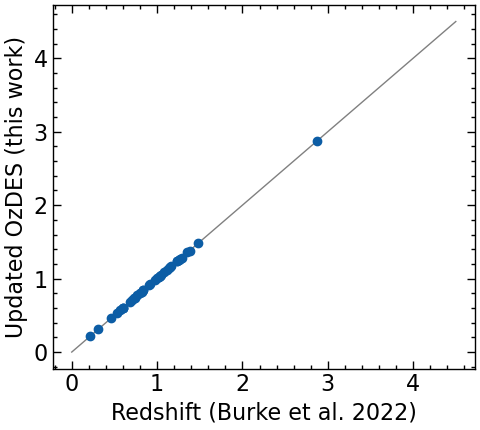

In [6]:
# Compare paper redshifts to new ozDES
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
ax.scatter(data_agn['z_sp'][idx_agn_ozdes], data_ozdes['z'][idx_ozdes])

print(len(data_agn['z_sp'][idx_agn_ozdes][data_agn['z_sp'][idx_agn_ozdes]>0])) # Some of these are from SDSS
print(len(data_ozdes['z'][idx_ozdes])) # Got several others

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Burke et al. 2022)')
ax.set_ylabel('Updated OzDES (this work)')

fig.tight_layout()

### Add latest DESI redshifts

In [7]:
data_desi = Table.read('desi_matches_z.csv', format = 'csv')

cat_desi = SkyCoord(data_desi['ra'], data_desi['dec'], unit='deg')

idx_desi, idx_agn_desi, d2d, d3d = cat_agn.search_around_sky(cat_desi, 0.5*u.arcsec)

idx_agn_desi


array([535, 567, 652, 656, 662, 668])

In [8]:
data_desi

﻿agn_name,ra,dec,id,z
str20,float64,float64,int64,float64
J022833.54-040141.58,37.1397,-4.0282,536,0.8415
J022631.23-042129.13,36.6301,-4.3581,568,0.2764
J022326.46-045706.17,35.8602,-4.9517,653,0.8247
J022415.76-052720.24,36.0657,-5.4556,657,0.5611
J022717.89-051623.98,36.8245,-5.2733,663,0.5655
J022319.71-052002.55,35.8321,-5.334,669,0.0


3
6


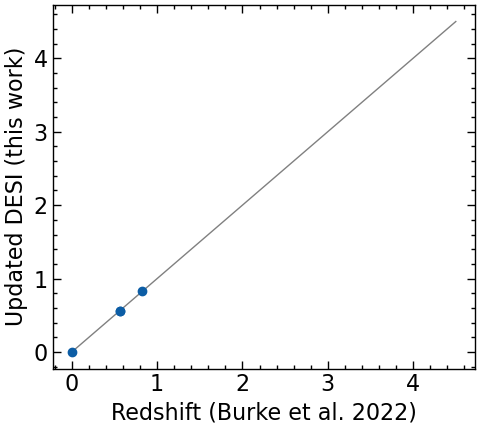

In [9]:
# Compare paper redshifts to new DESI
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
ax.scatter(data_agn['z_sp'][idx_agn_desi], data_desi['z'][idx_desi])

print(len(data_agn['z_sp'][idx_agn_desi][data_agn['z_sp'][idx_agn_desi]>0])) # Some of these are from SDSS
print(len(data_desi['z'][idx_desi])) # Got several others

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Burke et al. 2022)')
ax.set_ylabel('Updated DESI (this work)')

fig.tight_layout()

### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [10]:
M_star = data_agn[r'lgM']
M_star = np.array([d.split(' ')[0][1:] for d in M_star.data], dtype=float)

dChi2 = data_agn[r'dchi2']
dChi2 = np.array(dChi2, dtype=float)
mask_dwarf_agn = (M_star < 10) & (dChi2 > 2)

In [ ]:
# mask_specz = np.isfinite(data_agn[r'z_sp'].data)

# print(len(data_agn[mask_specz]))

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' or rvz_qual!='E' should have an optical spectrum

mask_spec_simbad = ((result_table['RVZ_WAVELENGTH']=='O') | (result_table['RVZ_WAVELENGTH']=='N'))  & (result_table['RVZ_QUAL']!='E') 

np.count_nonzero(mask_spec_simbad)

In [14]:
np.count_nonzero(mask_spec_simbad)

161

In [15]:
result_table[(result_table['RVZ_QUAL']!='E')]

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,RVZ_QUAL,RVZ_WAVELENGTH,Z_VALUE,RVZ_BIBCODE,FLUX_i,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,str1,str1,float64,object,float32,int32
DES J032850.22-271207.8,03 28 50.201,-27 12 07.81,7,7,--,--,0,C,O,2017AJ....153..107T,D,O,0.8030000,2017AJ....153..107T,19.181,6
Gaia DR3 5060529754629842816,03 30 25.4703,-27 28 21.939,14,14,0.274,0.460,90,A,O,2020yCat.1350....0G,,,--,,--,14
2XMM J033204.0-273726,03 32 04.06,-27 37 25.8,6,6,100.000,100.000,0,C,X,2016ApJS..224...15X,C,O,0.9660000,2015ApJ...815..129S,--,42
[VV2006] J033226.5-274036,03 32 26.4998,-27 40 35.910,14,14,0.135,0.251,90,A,O,2020yCat.1350....0G,C,O,1.0310000,2010ApJS..191..124S,19.762,43
[VV2006] J033227.0-274105,03 32 27.0132,-27 41 05.357,14,14,0.127,0.230,90,A,O,2020yCat.1350....0G,C,,0.7423000,2010A&A...512A..12B,19.11,44
[GYO2019] GS-44b,03 32 27.011,-27 41 05.44,7,7,13.000,0.000,90,C,R,2019ApJ...875...80G,,,--,,--,44
ACS-GC 90042521,03 32 30.2159,-27 45 04.590,8,8,--,--,0,C,O,2012MNRAS.426..360V,C,O,0.7368000,2011AJ....141...64X,21.623,45
PEARS s98500,03 32 29.9790,-27 45 29.886,9,9,--,--,0,C,O,2013ApJ...772...48P,D,O,2.2600000,2013ApJ...772...48P,21.1,46


display simbad bibcodes

DES: https://academic.oup.com/mnras/article/509/3/3547/6412546

OzDES? 2015MNRAS.452.3047Y

In [17]:
simbad_bibcodes, cnt = np.unique(result_table[mask_spec_simbad]['RVZ_BIBCODE'], return_counts=True)

bibcodes_descs = {
    '2009ApJ...703.1778S': 'Spitzer/SWIRE', 
        # SWIRE/ XMM-Newton /ELAIS-S1 field, E2, http://irsa.ipac.caltech.edu/applications/Gator/
    '2009ApJ...707.1779E': 'BLAST', 
        # Great Observatories Origins Deep Survey-South, C3, seems not available
    '2010ApJS..191..124S': 'VIMOS & DEIMOS', 
        # Chandra Deep Field South (CDF-S), C3, https://member.ipmu.jp/john.silverman/CDFS_data.html & https://www.eso.org/~vmainier/cdfs_pub/
    '2011AJ....141...64X': 'Magellan LDSS-3 Galaxies', 
        # GOODS-N / CDF-S, C3, used existing Magellan spectra to study galaxies
    '2011MNRAS.414..500H': 'Spitzer compilation', 
        # Lockman / ELAIS S1 / N1 / N2 / Bootes, E2, https://www.denebola.org/atlas/
    '2012MNRAS.425.2116C': 'ACES', 
        # The Arizona CDFS Environment Survey using Magellan, C3, also mentioned the uncertainty of PRIMUS, seems not available
    '2012MNRAS.426.3334M': 'ATLAS', 
        # The Australia Telescope Large Area Survey (ATLAS) of CDFS, C3, this paper only published redshift
    '2013A&A...559A..14L': 'VVDS', 
        # VLT Deep Survey final data release, 0226 − 04 Deep = X3, ECDFS = C3,  http://cesam.lam.fr/vvds 
    '2013ApJ...772...48P': 'PEARS', 
        # Emission-line Galaxies from the Hubble Space Telescope Probing Evolution and Reionization Spectroscopically (PEARS) Grism Survey. II., GOODS-S = C3, used PEARS data by HST Advanced Camera for Surveys 
    '2013ApJS..208...24L': 'Spitzer AGN', 
        # Spitzer selected Optical & NIR selected AGN, E2, used many sources including observed themselves 
    '2014A&A...562A..23G': 'VIPERS PDR-1', 
        # The VIMOS Public Extragalactic Survey (VIPERS), X3, http://vipers.inaf.it/ 
    '2015ApJ...815..129S': 'FMOS AGN', 
        # X-ray selected broad-line AGNs, C3, captured spectra using FMOS which is not publicly available
    '2015ApJS..219...12A': 'SDSS-III DR12', 
        # SDSS-III DR12, available via astroquery?
    '2016MNRAS.457..110M': 'SDSS & WISE AGN', 
        # northern XMM-XXL field, X3, used existing SDSS & WISE spectra to identify X-ray-selected AGNs
    '2017AJ....153..107T': 'WISE & DES AGN', 
        # Stripe 82 & DES Supernova Fields, C3+X3+E2, used WISE & DES to select AGNs and had OzDES catalog
    '2018A&A...609A..84S': 'VIPERS PDR-2', 
        # updated version of 2014A&A...562A..23G
    '2018A&A...613A..51P': 'SDSS DR14Q', 
        # Sloan Digital Sky Survey Quasar Catalog: Fourteenth data release, https://live-sdss4org-dr14.pantheonsite.io/algorithms/qso_catalog , also astroquery?
    '2018MNRAS.474.3875B': 'GAMA DR3', 
        # Galaxy And Mass Assembly: the G02 field, Herschel-ATLAS target selection and data release 3, G02=X3, http://www.gama-survey.org/dr3/ 
    '2020ApJS..249....3A': 'SDSS DR16', 
        # First Release from the APOGEE-2 Southern Survey and Full Release of eBOSS Spectra, available via astroquery?
    '2020ApJS..250....8L': 'SDSS DR16Q_v4', 
        # SDSS-IV eBOSS, https://data.sdss.org/sas/dr16/eboss/qso/DR16Q , also astroquery?
    '2021ApJS..256....4C': 'MMT/Hectospec', 
        # XMM-LSS, ELAIS-N1, and DEEP2-3, XMM-LSS=X3, https://mips.as.arizona.edu/~cnaw/Faint_Low_z/ 
    '2023ApJ...950..136Z': 'XMM-SERVS'
}

# visualization
table_bibcodes_descs = Table()
table_bibcodes_descs.add_column(simbad_bibcodes)
table_bibcodes_descs.add_column(Column(cnt, name='count'))
table_bibcodes_descs.add_column(Column([bibcodes_descs[i] for i in simbad_bibcodes], name='description'))
table_bibcodes_descs.sort('count', reverse=True)
table_bibcodes_descs

RVZ_BIBCODE,count,description
object,int64,str24
2016MNRAS.457..110M,50,SDSS & WISE AGN
2017AJ....153..107T,28,WISE & DES AGN
2012MNRAS.426.3334M,16,ATLAS
2010ApJS..191..124S,13,VIMOS & DEIMOS
2020ApJS..249....3A,12,SDSS DR16
2009ApJ...703.1778S,6,Spitzer/SWIRE
2015ApJS..219...12A,6,SDSS-III DR12
2018MNRAS.474.3875B,5,GAMA DR3
2023ApJ...950..136Z,3,XMM-SERVS


### Add new spec-z into the table

In [19]:
data_agn_updated = data_agn.copy()

data_agn_updated['z_simb'] = -1.
data_agn_updated['r_z_simb'] = ' '*19

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]


for j,i in enumerate(idx_simbad_specz):
    # Update if no existing spec-z
    # if ~np.isfinite(data_agn_updated[r'z_sp'][i]):
    data_agn_updated[r'z_simb'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated[r'r_z_simb'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]

# mask_specz_updated = np.isfinite(data_agn_updated[r'z_sp'].data)
# print(len(data_agn_updated[mask_specz_updated]))
# mask_specz = np.isfinite(data_agn[r'z_sp'].data)
# print(len(data_agn[mask_specz]))

# Overwrite new ozDES:
data_agn_updated['z_ozdes'] = -1.0
data_agn_updated['z_ozdes'][idx_agn_ozdes] = data_ozdes['z'][idx_ozdes]

# Overwrite new DESI:
data_agn_updated['z_desi'] = -1.0
data_agn_updated['z_desi'][idx_agn_desi] = data_desi['z'][idx_desi]

# Best spec-z
# Desi take priority over OzDES which takes priority over SIMBAD
data_agn_updated['z_best'] = data_agn['z_ph']
data_agn_updated['z_best'][data_agn_updated['z_sp']>0] = data_agn_updated['z_sp'][data_agn_updated['z_sp']>0]
data_agn_updated['z_best'][data_agn_updated['z_simb']>0] = data_agn_updated['z_simb'][data_agn_updated['z_simb']>0]
data_agn_updated['z_best'][data_agn_updated['z_ozdes']>0] = data_agn_updated['z_ozdes'][data_agn_updated['z_ozdes']>0]
data_agn_updated['z_best'][data_agn_updated['z_desi']>0] = data_agn_updated['z_desi'][data_agn_updated['z_desi']>0]


# Add ID
data_agn_updated['ID'] = np.arange(len(data_agn_updated)) + 1


print(len(data_agn_updated['z_ozdes'][data_agn_updated['z_ozdes']>0]))

print(len(data_agn_updated['z_best'][data_agn_updated['z_best']>0]))

print(len(data_agn_updated))

146
706
706


### Manually fix some:

In [20]:
if 'comment' not in data_agn_updated.colnames:
     data_agn_updated.add_column(table.Column(length=706, name='comment', dtype='U150'))

# ID: 47  0.61 arcsec away
data_agn_updated['z_best'][47-1] = 1.256
data_agn_updated['comment'][47-1] = '0.61 arcsec away, manually inputed redshift after changing SIMBAD radius parameter'

# ID: 108  SIMBAD shows two objects (0.33 and 0.05 arcsec seperation), but we believe they are the same object. The closer seperation object (0.05 arcsec) doesn't have a spectroscopic redshift, which causes the z=-1 issue. Therefore, I manually insert the spectroscopic redshift from the 0.33 arcsec seperation SIMBAD entry.
data_agn_updated['z_best'][108-1] = 2.6666
data_agn_updated['comment'][108-1] = 'SIMBAD shows two objects (0.33 and 0.05 arcsec seperation), but we believe they are the same object. The closer seperation object (0.05 arcsec) doesnt have a spectroscopic redshift, which causes the z=-1 issue. Therefore, I manually insert the spectroscopic redshift from the 0.33 arcsec seperation SIMBAD entry.'

# ID: 248  Bad quality SIMBAD, so script automatically ignore the redshift. Instead, I manually add the redshift.
data_agn_updated['z_best'][248-1] = 2.0052
data_agn_updated['comment'][248-1] = 'Bad quality SIMBAD, so script automatically ignore the redshift. Instead, I manually add the redshift.'

# ID: 568  Bad quality z according to SIMBAD, I manually add it
data_agn_updated['z_best'][568-1] = 1.993
data_agn_updated['comment'][568-1] = 'Bad quality SIMBAD, so script automatically ignore the redshift. Instead, I manually add the redshift.'

# ID: 575 Bad quality z according to SIMBAD, also potentially a galaxy according to SIMBAD???
data_agn_updated['z_best'][575-1] = 0.7717
data_agn_updated['comment'][575-1] = 'Bad quality SIMBAD, so script automatically ignore the redshift. Instead, I manually add the redshift. Also, potentially a galaxy according to SIMBAD???'

# ID: 580  Bad redshift, setting z=0
#data_agn_updated['z_best'][580-1] = 0
data_agn_updated['comment'][580-1] = 'Bad redshift, use photo-z'

# ID: 629  No spectroscopic z, only photometric z (SDSS z available in the table)
data_agn_updated['z_best'][629-1] = 0.9051742
data_agn_updated['comment'][629-1] = 'Bad SIMBAD redshift, using SDSS redshift'

# ID: 648  No z at all (SDSS z available in the table)
data_agn_updated['z_best'][648-1] = 1.809426
data_agn_updated['comment'][648-1] = 'Bad SIMBAD redshift, using SDSS redshift'


# ID: 673  Can't find a good redshift, so setting z = 0
#data_agn_updated['z_best'][673-1] = 0
data_agn_updated['comment'][673-1] = 'Bad redshift, use photo-z'

# ID: 675  Two SIMBAD objects, one galaxy and one X-ray source, neither have z
# --> Using redshift from Vipers PDR2 catalogue z = 1.53
data_agn_updated['z_best'][675-1] = 1.53
data_agn_updated['comment'][675-1] = 'No redshift from SIMBAD, using redshift from VIPERS'

/var/folders/l2/6gyggdg94_ddtk0bh6gt07vc0000gn/T/ipykernel_57441/2720241795.py:10: StringTruncateWarning: truncated right side string(s) longer than 150 character(s) during assignment
  data_agn_updated['comment'][108-1] = 'SIMBAD shows two objects (0.33 and 0.05 arcsec seperation), but we believe they are the same object. The closer seperation object (0.05 arcsec) doesnt have a spectroscopic redshift, which causes the z=-1 issue. Therefore, I manually insert the spectroscopic redshift from the 0.33 arcsec seperation SIMBAD entry.'
/var/folders/l2/6gyggdg94_ddtk0bh6gt07vc0000gn/T/ipykernel_57441/2720241795.py:22: StringTruncateWarning: truncated right side string(s) longer than 150 character(s) during assignment
  data_agn_updated['comment'][575-1] = 'Bad quality SIMBAD, so script automatically ignore the redshift. Instead, I manually add the redshift. Also, potentially a galaxy according to SIMBAD???'


In [21]:
###OzDES

# ID: 57  Galaxy, 0.62 away, using SIMBAD redshift
data_agn_updated['z_best'][57-1] = 0.1636
data_agn_updated['comment'][57-1] = '0.62 arcsec away, manually inputed redshift after changing SIMBAD radius parameter. https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%4024182556&Name=DES%20J032817.55-281000.7&submit=submit'


/var/folders/l2/6gyggdg94_ddtk0bh6gt07vc0000gn/T/ipykernel_57441/3603669331.py:5: StringTruncateWarning: truncated right side string(s) longer than 150 character(s) during assignment
  data_agn_updated['comment'][57-1] = '0.62 arcsec away, manually inputed redshift after changing SIMBAD radius parameter. https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%4024182556&Name=DES%20J032817.55-281000.7&submit=submit'


### Mark some that need to be skipped over (Stars, no data, etc)

In [22]:
# ID: 669  Star. Don't get rid of row, but set z = 0, and add a line in _pyqsofit to skip over this entry.
#data_agn_updated['z_best'][669-1] = 0
data_agn_updated['comment'][669-1] = 'CV star'

### Write data table

In [23]:
data_agn_updated.write('des_agn_updated.txt', format='ascii', overwrite=True)

## Visualize SIMBAD update

check selection bias

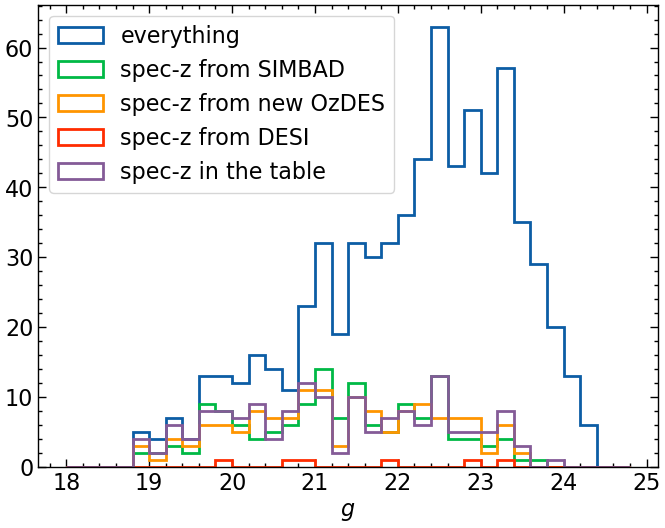

In [24]:
mask_specz_updated = np.isfinite(data_agn_updated['z_sp'].data)
mask_specz = data_agn_updated['z_simb']!=-1.
mask_specz_ozdes = data_agn_updated['z_ozdes']!=-1.
mask_specz_desi = data_agn_updated['z_desi']!=-1.


plt.hist(data_agn_updated['g'], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='everything')
plt.hist(data_agn_updated['g'][mask_specz_updated], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z from SIMBAD')
plt.hist(data_agn_updated['g'][mask_specz_ozdes], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z from new OzDES')
plt.hist(data_agn_updated['g'][mask_specz_desi], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z from DESI')
plt.hist(data_agn['g'][mask_specz], histtype='step', 
         linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z in the table')
plt.xlabel('$g$')
plt.legend(frameon=True, loc='upper left')

plot in skymap

/var/folders/l2/6gyggdg94_ddtk0bh6gt07vc0000gn/T/ipykernel_57441/2091786815.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


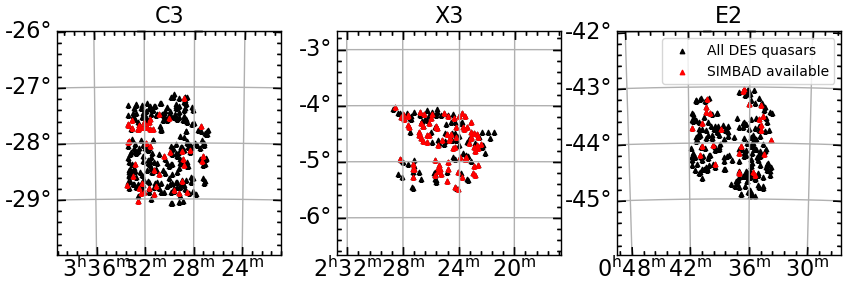

In [25]:
fig = plt.figure(figsize=[8, 8], dpi=100)

text_coords = ['52d30m -28d', '36d10m -4d40m', '9d30m -44d']
fields = ['C3', 'X3', 'E2']

axlist = []
for i, (text_coord, field) in enumerate(zip(text_coords, fields)): 
    center_coord = SkyCoord(text_coord)
    width = 1*u.deg
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [1, 1]
    wcs.wcs.cdelt = [-width.to_value(u.deg), width.to_value(u.deg)]
    wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    ax1 = plt.axes([0.35*i, 0, 0.28, 1], projection=wcs)
    ax1.set_aspect('equal')
    ax1.scatter(cat_agn.ra, cat_agn.dec, 
                transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, 
                label='All DES quasars')
    mask_simbad_available = data_agn_updated['z_simb']!=-1.
    ax1.scatter(cat_agn.ra[mask_simbad_available], cat_agn.dec[mask_simbad_available], 
                transform=ax1.get_transform('world'), s=10, marker='^', color='r', alpha=1, 
                label='SIMBAD available')
    ax1.grid()
    ax1.set_title(field)
    ax1.coords['ra'].set_auto_axislabel(False)
    ax1.coords['dec'].set_auto_axislabel(False)
    ax1.set_xlim(-2, 2) # using deg as unit as defined in wcs.wcs.cdelt
    ax1.set_ylim(-2, 2)
    axlist.append(ax1)

plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()
# fig.savefig('cosmos.eps', format='eps')

export source profile

In [35]:
# TODO

# SIMBAD overwrites Burke2022 so add Burke2022 first

profile = table.Table(data=np.array([['0', 
                                      np.count_nonzero(~np.isnan(data_agn_updated['z_sp'])), 
                                      '-', 
                                      'Burke2022 specz', 
                                      '-'],
                                     ['1', 
                                      sum(data_agn_updated['z_simb']!=-1), 
                                      '-', 
                                      'SIMBAD',
                                      '-'],]), 
                      names=['source', 
                             'count', 
                             'bibcode', 
                             'description', 
                             'refcode'], 
                      dtype=('U6', 'i4', 'U19', 'U26', 'U21'))

# left alignment
for col in profile.columns: profile[col].format='<'

# Burke2022 bibcodes
descs_bibcodes = {
    '2dF': '2020MNRAS.496...19L', 
    #TODO ...
}

# add Burke2022
idx_has_simbad = data_agn_updated['z_simb']!=-1.
for i, (source, cnt) in enumerate(zip(*np.unique(data_agn_updated['z_sp source'][~idx_has_simbad], return_counts=True))): 
    if source!='None': 
        profile.add_row(['Burke2022_%02d'%(i+1), 
                         cnt, 
                         '?', 
                         source, 
                         'Burke2022'])

# add SIMBAD
for i, bibcode in enumerate(simbad_bibcodes): 
    profile.add_row(['SIMBAD_%02d'%(i+1), 
                     np.count_nonzero(data_agn_updated['r_z_simb']==bibcode), 
                     bibcode, 
                     bibcodes_descs[bibcode], 
                     get_ref(bibcode)])

# NOTE: OzDES data is the same as previous Burke22 paper
# # add OzDES
# idx_has_ozdes = data_agn_updated['c']!=-1.
# cnt = np.count_nonzero(idx_has_ozdes)
# bibcode = '2020MNRAS.496...19L'
# profile.add_row(['OzDES', cnt, bibcode, 'new OzDES', get_ref(bibcode)])

# add DESI
idx_has_desi = data_agn_updated['z_desi']!=-1.
cnt = np.count_nonzero(idx_has_desi)
profile.add_row(['DESI', cnt, '?', 'DESI', 'DESI2023'])


profile.pprint_all()

   source    count       bibcode             description              refcode       
------------ ----- ------------------- ------------------------ --------------------
0            146   -                   Burke2022 specz          -                   
1            160   -                   SIMBAD                   -                   
Burke2022_01 44    ?                   2dF                      Burke2022           
Burke2022_02 1     ?                   2dFG                     Burke2022           
Burke2022_03 3     ?                   ACES                     Burke2022           
Burke2022_04 1     ?                   GAMA                     Burke2022           
Burke2022_06 3     ?                   PanS                     Burke2022           
Burke2022_07 2     ?                   SDSS                     Burke2022           
Burke2022_08 1     ?                   SNLS                     Burke2022           
Burke2022_09 1     ?                   VVDS                     B

In [53]:
# save a simplified table for paper
# Skip the first two rows
profile_paper = profile[profile['bibcode']!='-'].copy()
# profile_paper = profile_paper['count', 'refcode', 'description']


for col in profile_paper.columns: 
    profile_paper[col].format='<'
profile_paper.sort(['count'], reverse=True)
profile_paper = profile_paper['count', 'refcode', 'description']
# profile_paper[np.where(profile_paper['refcode']=='\citet{van der Wel2021}')[0][0]]['refcode'] = '\citet{vanderWel2021}'
# profile_paper[np.where(profile_paper['refcode']=='\citet{Pâris2014}')[0][0]]['refcode'] = '\citet{Paris2014}'
# profile_paper[np.where(profile_paper['refcode']=='\citet{Pâris2018}')[0][0]]['refcode'] = '\citet{Paris2018}'
# profile_paper[np.where(profile_paper['refcode']=='\citet{Le Fèvre2013}')[0][0]]['refcode'] = '\citet{LeFevre2013}'

profile_paper.pprint_all()
profile_paper.write('source_profile.txt', overwrite=True, format='latex')

count       refcode              description       
----- -------------------- ------------------------
50    Menzel2016           SDSS & WISE AGN         
44    Burke2022            2dF                     
28    Tie2017              WISE & DES AGN          
16    Mao2012              ATLAS                   
13    Silverman2010        VIMOS & DEIMOS          
12    Ahumada2020          SDSS DR16               
6     Sacchi2009           Spitzer/SWIRE           
6     Alam2015             SDSS-III DR12           
6     DESI2023             DESI                    
5     Baldry2018           GAMA DR3                
3     Garilli2014          VIPERS PDR-1            
3     Burke2022            ACES                    
3     Zou2023              XMM-SERVS               
3     Burke2022            PanS                    
3     Pâris2018            SDSS DR14Q              
2     Scodeggio2018        VIPERS PDR-2            
2     Suh2015              FMOS AGN                
2     Cooper

visualize our update

In [54]:
data_agn_updated['z_before'] = data_agn_updated['z_ph']
data_agn_updated['z_before'][data_agn_updated['z_sp']>0] = data_agn_updated['z_sp'][data_agn_updated['z_sp']>0]

data_agn_updated['z_after'] = data_agn_updated['z_before']
data_agn_updated['z_after'][data_agn_updated['z_simb']>0] = data_agn_updated['z_simb'][data_agn_updated['z_simb']>0]
data_agn_updated['z_after'][data_agn_updated['z_ozdes']>0] = data_agn_updated['z_ozdes'][data_agn_updated['z_ozdes']>0]
data_agn_updated['z_after'][data_agn_updated['z_desi']>0] = data_agn_updated['z_desi'][data_agn_updated['z_desi']>0]

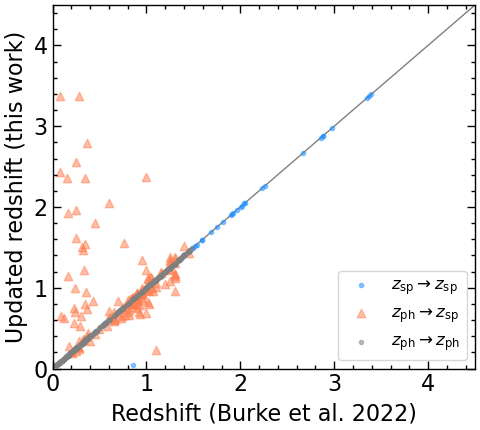

In [55]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_sp_before = data_agn_updated['z_sp']>0
mask_sp_after = (data_agn_updated['z_sp']>0) | (data_agn_updated['z_simb']>0) | (data_agn_updated['z_ozdes']>0) | (data_agn_updated['z_desi']>0)

mask_sp2sp = mask_sp_before & mask_sp_after
ax.scatter(data_agn_updated['z_before'][mask_sp2sp], data_agn_updated['z_after'][mask_sp2sp], 
           marker='.', color='dodgerblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2sp = (~mask_sp_before) & mask_sp_after
ax.scatter(data_agn_updated['z_before'][mask_ph2sp], data_agn_updated['z_after'][mask_ph2sp], 
           marker='^', color='coral', label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2ph = (~mask_sp_before) & (~mask_sp_after)
ax.scatter(data_agn_updated['z_before'][mask_ph2ph], data_agn_updated['z_after'][mask_ph2ph], 
           marker='.', color='gray', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', alpha=0.5)

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Burke et al. 2022)')
ax.set_ylabel('Updated redshift (this work)')
ax.legend(frameon=True, loc='lower right', fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

check inconsistency

In [56]:
# No Z_sp-Z_sp or updated database, so seems like no inconsistency to check in this (redshift) stage. 

In [57]:

list(zip(*np.unique(data_agn_updated['z_sp source'], return_counts=True)))

[('2dF', 62),
 ('2dFG', 1),
 ('ACES', 9),
 ('GAMA', 8),
 ('None', 560),
 ('PanS', 27),
 ('SDSS', 34),
 ('SNLS', 2),
 ('VIPE', 1),
 ('VVDS', 2)]

In [58]:
len(data_agn_updated)

706